In [2]:
###关于数据的可视化
# matplotlib,seaborn,pyecharts

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# plt.style.use('ggplot')  #风格设置近似R这种的ggplot库
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
import itertools
from math import *
from collections import Counter

In [3]:
import numpy as np
import pandas as pd

In [4]:
#  忽略弹出的warnings
import warnings
warnings.filterwarnings('ignore')  

In [5]:
x_feature = ['收盘价','流通股本','总股本','每股未分配利润(元/股)','每股资本公积(元/股)',
       '净利润同必增长(%)','基本每股收益','每股净资产(元/股)','每股现金流量净额(元/股)','上市年限','交通运输、仓储和邮政业',
       '住宿和餐饮业','信息传输、软件和信息技术服务业','农、林、牧、渔业']

In [7]:
data_zscore = pd.read_csv(r'C:\Users\ryan\Desktop\data2.csv',encoding="gbk")
x_val2 = data_zscore[x_feature]
y_val2 = data_zscore['是否高转送']
X_train2, X_test2, y_train2, y_test2 = train_test_split(x_val2, y_val2, test_size = 0.3, random_state = 0) # random_state = 0 每次切分的数据都一样

In [11]:
# 构建参数组合
param_grid = {'C': [0.01,0.1, 1, 10, 100, 1000,],
                            'penalty': [ 'l1', 'l2']}

grid_search = GridSearchCV(LogisticRegression(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定10折
grid_search.fit(X_train2, y_train2) # 使用训练集学习算法

results = pd.DataFrame(grid_search.cv_results_) 
best = np.argmax(results.mean_test_score.values)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.5f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'penalty': 'l2'}
Best cross-validation score: 0.75825


In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=100.0) # 构建逻辑回归分类器
clf.fit(x_val2, y_val2)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
#打印精度
print(np.mean(clf.predict(X_test2) == y_test2))

0.7634283498157843


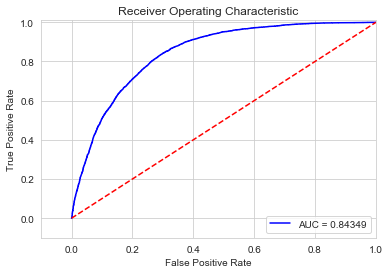

In [18]:
y_pred1_prob = clf.predict_proba(x_val2)[:, 1]  # 阈值默认值为0.5

fpr, tpr, thresholds = roc_curve(y_val2,y_pred1_prob)
roc_auc = auc(fpr,tpr)

# 绘制 ROC曲线
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.5f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Recall metric in the testing dataset:  0.7467132053519488


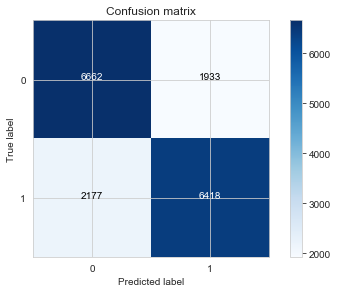

In [20]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    打印混淆矩阵
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
##################################################################################

# Compute confusion matrix
predicted1 = clf.predict(x_val2)
cnf_matrix = confusion_matrix(y_val2, predicted1)  # 生成混淆矩阵
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Recall metric in the testing dataset:  0.995814307458143
Recall metric in the testing dataset:  0.9764079147640792
Recall metric in the testing dataset:  0.9402587519025876
Recall metric in the testing dataset:  0.867579908675799
Recall metric in the testing dataset:  0.7488584474885844
Recall metric in the testing dataset:  0.6206240487062404
Recall metric in the testing dataset:  0.4771689497716895
Recall metric in the testing dataset:  0.3146879756468798
Recall metric in the testing dataset:  0.17123287671232876


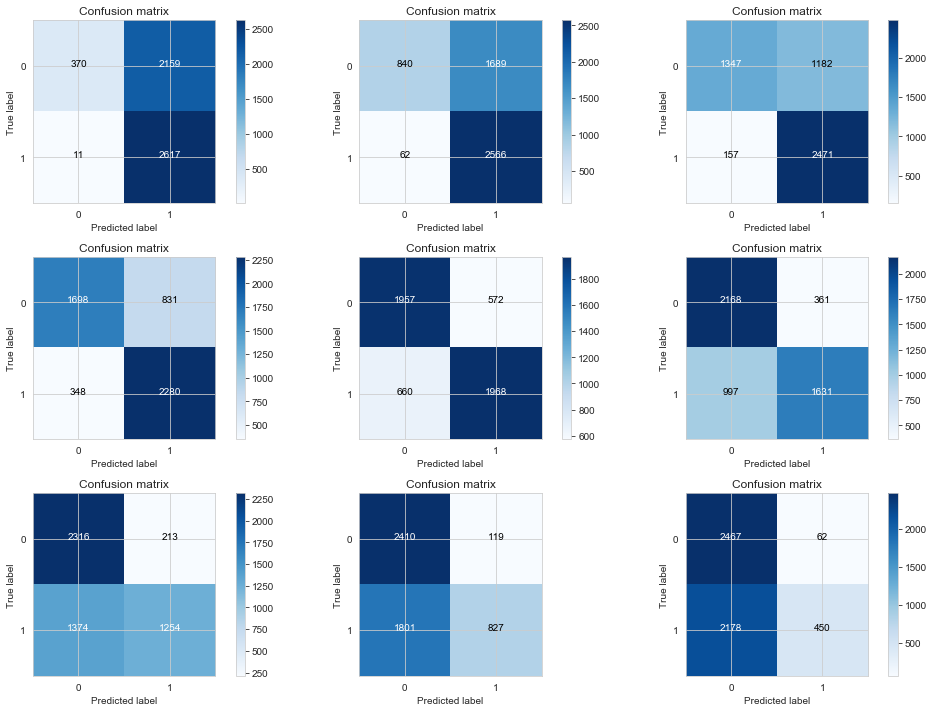

In [23]:
y_pred_proba = grid_search.predict_proba(X_test2)  #predict_prob 获得一个概率值

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]  # 设定不同阈值

plt.figure(figsize=(15,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba[:,1] > i#预测出来的概率值是否大于阈值 
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test2, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names)

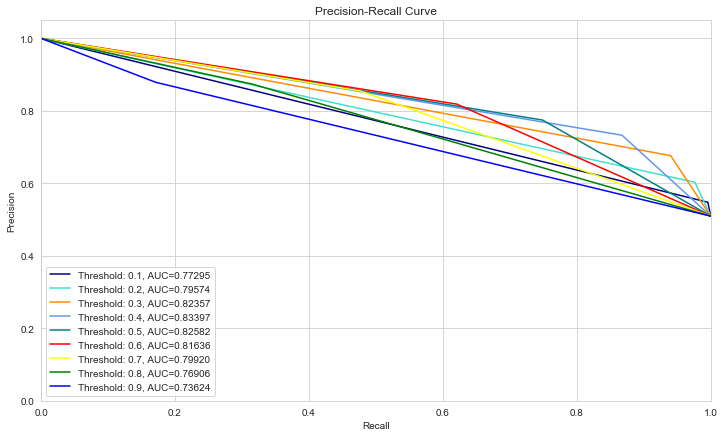

In [25]:
from itertools import cycle

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(12,7))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_proba[:,1] > i #预测出来的概率值是否大于阈值  

    precision, recall, thresholds = precision_recall_curve(y_test2, y_test_predictions_prob)
    area = auc(recall, precision)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s, AUC=%0.5f' %(i , area))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

# svm-bagging

In [26]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
def svm_c1(x_train, x_test, y_train):
    print('训练中...')
    svc = SVC(kernel='rbf', class_weight='balanced')
    clf = BaggingClassifier(base_estimator=svc, n_estimators=20,max_samples=1.0, max_features=1.0, 
                            bootstrap=True,bootstrap_features=False, n_jobs=1, random_state=1)
    param_grid = [{'base_estimator':[SVC(kernel='rbf', class_weight='balanced',C=4.5)],#没4
                   'n_estimators': [20], 'max_samples': [0.95], #[20]
                   'max_features': [0.8]}]
    #param_grid：是一个列表，列表里是算法对象的超参数的取值，用字典存储
    grid = GridSearchCV(clf, param_grid, cv=6, n_jobs=-1)
    #clf.fit(x_train, y_train)
    #predict = clf.predict(x_test)
    # 训练模型
    clf = grid.fit(x_train, y_train)
    # 计算测试集精度
    best_estimator = grid.best_estimator_
    predict = best_estimator.predict(x_test)
    print(grid.best_score_)    #查看最佳分数(此处为f1_score)
    print(grid.best_params_)   #查看最佳参数
    print(np.mean(clf.predict(x_test) == y_test2))  #查看最佳精度

In [27]:
svm_c1(X_train2, X_test2, y_train2)

训练中...
0.7980555009949372
{'base_estimator': SVC(C=4.5, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'max_features': 0.8, 'max_samples': 0.95, 'n_estimators': 20}
0.8014349427961993
